In [1]:
import uuid, sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import math
import random
import matplotlib.pyplot as plt

from sklearn import metrics
from scipy import stats
from collections import Counter

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 2 on the node
print(torch.cuda.get_device_name(0))

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
import pytorch_lightning as pl
from torch.optim import AdamW

torch.manual_seed(0)

from accelerate import Accelerator
torch.cuda.empty_cache()
import training_utils.partitioning_utils as pat_utils
from tqdm import trange

Tesla V100-SXM2-32GB


/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'Could not load this library: /work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


### Loading PPint and meta-analysis data

In [13]:
Df_train = pd.read_csv("/work3/s232958/data/PPint_DB/PPint_train_w_pbd_lens.csv",index_col=0).reset_index(drop=True)
Df_test = pd.read_csv("/work3/s232958/data/PPint_DB/PPint_test_w_pbd_lens.csv",index_col=0).reset_index(drop=True)

Df_train["target_chain"] = [str(row.ID1[:5]+row.ID1[-1]) for __, row in Df_train.iterrows()]
Df_train["binder_chain"] = [str(row.ID2[:5]+row.ID2[-1]) for __, row in Df_train.iterrows()]

Df_test["target_chain"] = [str(row.ID1[:5]+row.ID1[-1]) for __, row in Df_test.iterrows()]
Df_test["binder_chain"] = [str(row.ID2[:5]+row.ID2[-1]) for __, row in Df_test.iterrows()]

interaction_df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal_w_pbd_lens.csv").drop(columns = ["binder_id", "target_id"]).rename(columns = {
    "target_id_mod" : "target_id",
    "target_binder_ID" : "binder_id",
})

# Interaction Dict
interaction_df_shuffled = interaction_df.sample(frac=1, random_state=0).reset_index(drop=True)
interaction_df_shuffled

,binder_chain,target_chains,binder,binder_seq,target_seq,target_id,binder_id,seq_len_binder,seq_len_target,pdb_len_binder,pdb_len_target
0,A,"[""B""]",True,DIVEEAHKLLSRAMSEAMENDDPDKLRRANELYFKLEEALKNNDPK...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_124,62,101,62,101
1,A,"[""B""]",False,SEELVEKVVEEILNSDLSNDQKILETHDRLMELHDQGKISKEEYYK...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,EGFR_2,EGFR_2_149,58,621,58,621
2,A,"[""B""]",False,TINRVFHLHIQGDTEEARKAHEELVEEVRRWAEELAKRLNLTVRVT...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_339,65,101,65,101
3,A,"[""B""]",False,DDLRKVERIASELAFFAAEQNDTKVAFTALELIHQLIRAIFHNDEE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1234,64,101,64,101
4,A,"[""B""]",False,DEEVEELEELLEKAEDPRERAKLLRELAKLIRRDPRLRELATEVVA...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_48,65,165,65,165
...,...,...,...,...,...,...,...,...,...,...,...
3527,A,"[""B""]",False,SEDELRELVKEIRKVAEKQGDKELRTLWIEAYDLLASLWYGAADEL...,TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFK...,SARS_CoV2_RBD,SARS_CoV2_RBD_25,63,195,63,195
3528,A,"[""B""]",False,TEEEILKMLVELTAHMAGVPDVKVEIHNGTLRVTVNGDTREARSVL...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2027,65,101,65,101
3529,A,"[""B""]",False,VEELKEARKLVEEVLRKKGDQIAEIWKDILEELEQRYQEGKLDPEE...,DYSFSCYSQLEVNGSQHSLTCAFEDPDVNTTNLEFEICGALVEVKC...,IL7Ra,IL7Ra_90,63,193,63,193
3530,A,"[""B""]",False,DAEEEIREIVEKLNDPLLREILRLLELAKEKGDPRLEAELYLAFEK...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1605,65,101,65,101


## ESM-IF

In [10]:
class CLIP_PPint_class(Dataset):
    def __init__(
        self,
        dframe,
        path,
        embedding_dim=512,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)

        # lengths
        self.max_blen = self.dframe["pdb_len_binder"].max()
        self.max_tlen = self.dframe["pdb_len_target"].max()

        # paths
        self.encoding_path  = path

        # index & storage
        self.dframe.set_index("target_binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = parts[0]+"_"+parts[2]
            bnd_id = parts[-3]+"_"+parts[-1]

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_path, f"{tgt_id}.npy"))     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_path, f"{bnd_id}.npy"))     # [Lb, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            self.samples.append((b_emb, t_emb))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        label = torch.tensor(1, dtype=torch.float32)  # single scalar labe
        return binder_emb, target_emb, label

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, labels

emb_path = "/work3/s232958/data/PPint_DB/esmif_embeddings_noncanonical"

testing_Dataset = CLIP_PPint_class(
    Df_test,
    path=emb_path,
    embedding_dim=512
)

### Getting indeces of non-dimers
indices_non_dimers_Df = Df_test[~Df_test["dimer"]]
indices_non_dimers = Df_test[~Df_test["dimer"]].index.tolist()
indices_non_dimers[:5]

non_dimers_Dataset = CLIP_PPint_class(
    indices_non_dimers_Df,
    path=emb_path,
    embedding_dim=512
)

#Loading ESM2 embeddings and contacts: 100%|█████████████████████████████████████████| 122/122 [00:00<00:00, 275.35it/s]


In [11]:
### Getting accessions of non-dimers
accessions = [Df_test.loc[index].target_binder_id for index in indices_non_dimers_val]
emb_b, emb_t, labels = testing_Dataset._get_by_name(accessions[:5])
labels

tensor([1., 1., 1., 1., 1.])

In [14]:
class CLIP_Meta_class(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim=512,
        embedding_pad_value=-5000.0
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)
        self.max_blen = self.dframe["pdb_len_target"].max()
        self.max_tlen = self.dframe["pdb_len_target"].max()

        # paths
        self.encoding_bpath, self.encoding_tpath = paths

        # index & storage
        self.dframe.set_index("binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings"):
            lbl = torch.tensor(int(self.dframe.loc[accession, "binder"]))
            parts = accession.split("_")
            tgt_id = "_".join(parts[:-1])
            bnd_id = accession

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_tpath, f"{tgt_id}.npy"))     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_bpath, f"{bnd_id}.npy"))     # [Lb, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            self.samples.append((b_emb, t_emb, lbl))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr, lbls = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        return binder_emb, target_emb, lbls

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, labels

bemb_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_binders"
temb_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_targets"

validation_Dataset = CLIP_Meta_class(
    # interaction_df_shuffled[:len(Df_test)],
    interaction_df_shuffled,
    paths=[bemb_path, temb_path],
    embedding_dim=512
)

#Loading ESM2 embeddings: 100%|████████████████████████████████████████████████████| 3532/3532 [00:21<00:00, 168.17it/s]


In [23]:
test_dataloader = DataLoader(testing_Dataset, batch_size=10, shuffle=False)
non_dimers_dataloader = DataLoader(non_dimers_Dataset, batch_size=10, shuffle=False)
validation_dataloader = DataLoader(validation_Dataset, batch_size=10, shuffle=False, drop_last = False)

### Pre-trained model

In [20]:
embedding_dimension = 512

def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=embedding_dimension, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value
        self.embed_dimension = 512

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init

        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension*2
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)  # For residual additions

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
        )
        
    def forward(self, pep_input, prot_input, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input, padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input, padding_value=self.padding_value)
 
        # Initialize residual states
        pep_emb = pep_input.clone()
        prot_emb = prot_input.clone()
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            pep_emb = pep_emb + pep_trans  
            prot_emb = prot_emb + prot_trans

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding), dim=-1)
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding), dim=-1)
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1)
        
        return logits

    def training_step(self, batch, device):
        embedding_pep, embedding_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        
        positive_logits = self.forward(embedding_pep, embedding_prot)
        
        # Negative indexes
        rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)         
        
        negative_logits = self(embedding_pep[rows,:,:], 
                          embedding_prot[cols,:,:], 
                          int_prob=0.0)

        # loss of predicting partner using peptide
        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
 
        # loss of predicting peptide using partner
        negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))
        
        loss = (positive_loss + negative_loss) / 2
 
        # del partner_prediction_loss, peptide_prediction_loss, embedding_pep, embedding_prot
        torch.cuda.empty_cache()
        return loss

    def validation_step_PPint(self, batch, device):
        # Predict on random batches of training batch size
        embedding_pep, embedding_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        
        with torch.no_grad():

            positive_logits = self(embedding_pep, embedding_prot)
            
            # loss of predicting partner using peptide
            positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
            
            # Negaive indexes
            rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)
            
            negative_logits = self(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)
    
            negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))

            loss = (positive_loss + negative_loss) / 2
           
            logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            
            # Fill diagonal with positive scores
            diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(embedding_prot.size(0)).to(self.device)
            peptide_predictions = logit_matrix.argmax(dim=0)
            peptide_ranks = logit_matrix.argsort(dim=0).diag() + 1
            peptide_mrr = (peptide_ranks).float().pow(-1).mean()
            
            # partner_accuracy = partner_predictions.eq(labels).float().mean()
            peptide_accuracy = peptide_predictions.eq(labels).float().mean()
    
            k = 3
            peptide_topk_accuracy = torch.any((logit_matrix.topk(k, dim=0).indices - labels.reshape(1, -1)) == 0, dim=0).sum() / logit_matrix.shape[0]
    
            del logit_matrix,positive_logits,negative_logits,embedding_pep,embedding_prot

            return loss, peptide_accuracy, peptide_topk_accuracy
    
    def validation_step_MetaDataset(self, batch, device):
        embedding_binder, embedding_target, labels = batch
        embedding_binder = embedding_binder.to(device)
        embedding_target = embedding_target.to(device)
        labels = labels.to(device).float()
    
        with torch.no_grad():
            logits = self.forward(embedding_binder, embedding_target)
            logits = logits.float()
            loss = F.binary_cross_entropy_with_logits(logits.view(-1), labels.view(-1))
            return logits, loss

    def calculate_logit_matrix(self,embedding_pep,embedding_prot):
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        
        positive_logits = self(embedding_pep, embedding_prot)
        negative_logits = self(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        return logit_matrix

In [21]:
model = MiniCLIP_w_transformer_crossattn().to("cuda")
path = "/work3/s232958/data/trained/original_architecture/21733d5f-de5a-4386-a5a2-45c1ff68c902/21733d5f-de5a-4386-a5a2-45c1ff68c902_checkpoint_6/21733d5f-de5a-4386-a5a2-45c1ff68c902_checkpoint_epoch_6.pth"
checkpoint = torch.load(path, weights_only=False, map_location=torch.device('cpu'))
# print(list(checkpoint["model_state_dict"]))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  

MiniCLIP_w_transformer_crossattn(
  (transformerencoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=1024, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1024, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (prot_embedder): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=Tr

### test-data

In [26]:
interaction_scores_pos = []
interaction_scores_neg = []    

for batch in tqdm(test_dataloader, total=round(len(Df_test)/10), desc="#Iterating through batched data"):
    b_emb, t_emb, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():

        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        
        positive_logits = model(embedding_pep, embedding_prot)
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = model(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)
        
        # print(logit_matrix)
        interaction_scores_pos.append(positive_logits)
        interaction_scores_neg.append(negative_logits)

# Convert list of tensors to single 1D tensors
pos_logits = torch.cat(interaction_scores_pos).detach().cpu().numpy()
neg_logits = torch.cat(interaction_scores_neg).detach().cpu().numpy()
print("Positives:", pos_logits.shape)
print("Negatives:", neg_logits.shape)

#Iterating through batched data: 50it [00:07,  6.37it/s]                                                                

Positives: (494,)
Negatives: (2211,)


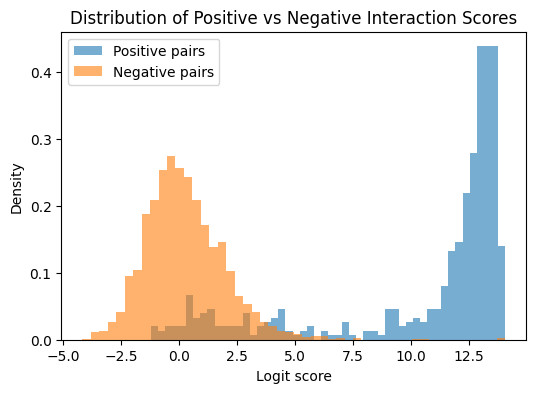

In [27]:
plt.figure(figsize=(6, 4))
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
plt.legend()
plt.show()

#### non-dimers

In [29]:
interaction_scores = []
for batch in tqdm(non_dimers_dataloader, total=round(len(non_dimers_Dataset)/10), desc="#Iterating through batched data"):
    b_emb, t_emb, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():

        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        
        positive_logits = model(embedding_pep, embedding_prot)
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = model(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)
        
        # print(logit_matrix)
        interaction_scores_pos.append(positive_logits)
        interaction_scores_neg.append(negative_logits)

# Convert list of tensors to single 1D tensors
pos_logits = torch.cat(interaction_scores_pos).detach().cpu().numpy()
neg_logits = torch.cat(interaction_scores_neg).detach().cpu().numpy()
print("Positives:", pos_logits.shape)
print("Negatives:", neg_logits.shape)

#Iterating through batched data: 13it [00:01,  7.22it/s]                                                                

Positives: (616,)
Negatives: (2752,)


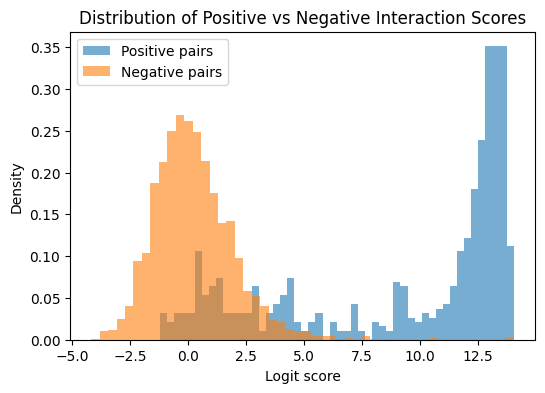

In [30]:
plt.figure(figsize=(6, 4))
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
plt.legend()
plt.show()

#### meta-binders

In [33]:
# Loading batches
interaction_scores = []

for batch in tqdm(validation_dataloader, total = round(len(interaction_df_shuffled)/10),  desc= "#Iterating through batched data"):
    b_emb, t_emb, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():
        positive_logits = model(embedding_pep, embedding_prot)
        interaction_scores.append(positive_logits.unsqueeze(0))

predicted_interaction_scores = np.concatenate([batch_score.cpu().detach().numpy().reshape(-1,) for batch_score in interaction_scores])
interaction_probabilities = np.concatenate([torch.sigmoid(batch_score[0]).cpu().numpy() for batch_score in interaction_scores])

pos_logits, neg_logits = [], []
for i, row in interaction_df_shuffled.iterrows():
    logit = predicted_interaction_scores[i]
    if row.binder == False:
        neg_logits.append(logit)
    elif row.binder == True:
        pos_logits.append(logit)

#Iterating through batched data: 354it [00:19, 17.77it/s]                                                               


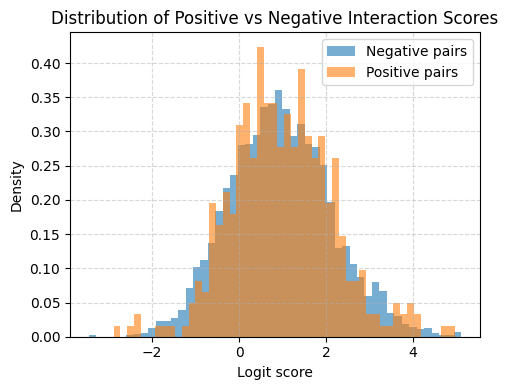

In [35]:
plt.figure(figsize=(5, 4))
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
# --- Simple grid behind ---
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## ESM-IF + ESM-2

In [34]:
class CLIP_PPint_w_esmIF(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim_struct=512,
        embedding_dim_seq=1280,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim_seq = embedding_dim_seq
        self.embedding_dim_struct = embedding_dim_struct
        self.emb_pad = embedding_pad_value

        # lengths
        self.max_blen_seq = self.dframe["seq_binder_len"].max()
        self.max_tlen_seq = self.dframe["seq_target_len"].max()
        self.max_blen_struct = self.dframe["pdb_len_binder"].max()
        self.max_tlen_struct = self.dframe["pdb_len_target"].max()

        # paths
        self.seq_encodings_path, self.struct_encodings_path = paths

        # index & storage
        self.dframe.set_index("target_binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = parts[0]+"_"+parts[2]
            bnd_id = parts[-3]+"_"+parts[-1]

            ### --- SEQ embeddings (pad to fixed lengths) --- ###
            # laod embeddings
            t_emb_seq = np.load(os.path.join(self.seq_encodings_path, f"{tgt_id}.npy"))     # [Lt, D]
            b_emb_seq = np.load(os.path.join(self.seq_encodings_path, f"{bnd_id}.npy"))     # [Lb, D]
            t_emb_struct = np.load(os.path.join(self.struct_encodings_path, f"{tgt_id}.npy"))     # [Lt, D]
            b_emb_struct = np.load(os.path.join(self.struct_encodings_path, f"{bnd_id}.npy"))     # [Lb, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb_seq.shape[1] != self.embedding_dim_seq or b_emb_seq.shape[1] != self.embedding_dim_seq:
                raise ValueError("Embedding dim mismatch with 'embedding_dim_seq'.")
            if t_emb_struct.shape[1] != self.embedding_dim_struct or b_emb_struct.shape[1] != self.embedding_dim_struct:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")
                
            # add -5000 to all the padded target rows
                ### SEQ_embeddings ###
            if t_emb_seq.shape[0] < self.max_tlen_seq:
                t_emb_seq = np.concatenate([t_emb_seq, np.full((self.max_tlen_seq - t_emb_seq.shape[0], t_emb_seq.shape[1]), self.emb_pad, dtype=t_emb_seq.dtype)], axis=0)
            else:
                t_emb_seq = t_emb_seq[: self.max_tlen_seq] # no padding was used
            if b_emb_seq.shape[0] < self.max_blen_seq:
                b_emb_seq = np.concatenate([b_emb_seq, np.full((self.max_blen_seq - b_emb_seq.shape[0], b_emb_seq.shape[1]), self.emb_pad, dtype=b_emb_seq.dtype)], axis=0)
            else:
                b_emb_seq = b_emb_seq[: self.max_blen_seq] # no padding was used

                ### STRUCT_embeddings ###
            if t_emb_struct.shape[0] < self.max_tlen_struct:
                t_emb_struct = np.concatenate([t_emb_struct, np.full((self.max_tlen_struct - t_emb_struct.shape[0], t_emb_struct.shape[1]), self.emb_pad, dtype=t_emb_struct.dtype)], axis=0)
            else:
                t_emb_struct = t_emb_struct[: self.max_tlen_struct] # no padding was used
            if b_emb_struct.shape[0] < self.max_blen_struct:
                b_emb_struct = np.concatenate([b_emb_struct, np.full((self.max_blen_struct - b_emb_struct.shape[0], b_emb_struct.shape[1]), self.emb_pad, dtype=b_emb_struct.dtype)], axis=0)
            else:
                b_emb_struct = b_emb_struct[: self.max_blen_struct] # no padding was used

            self.samples.append((b_emb_seq, t_emb_seq, b_emb_struct, t_emb_struct))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_emb_seq, t_emb_seq, b_emb_struct, t_emb_struct = self.samples[idx]
        b_emb_seq, t_emb_seq = torch.from_numpy(b_emb_seq).float(), torch.from_numpy(t_emb_seq).float()
        b_emb_struct, t_emb_struct = torch.from_numpy(b_emb_struct).float(), torch.from_numpy(t_emb_struct).float()
        label = torch.tensor(1, dtype=torch.float32)  # single scalar labe
        return b_emb_seq, t_emb_seq, b_emb_struct, t_emb_struct, label

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_emb_seq_list, t_emb_seq_list, b_emb_struct_list, t_emb_struct_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b_emb_seq  = torch.stack([torch.as_tensor(x) for x in b_emb_seq_list],  dim=0)  # [B, ...]
        t_emb_seq  = torch.stack([torch.as_tensor(x) for x in t_emb_seq_list],  dim=0)  # [B, ...]
        
        b_emb_struct  = torch.stack([torch.as_tensor(x) for x in b_emb_struct_list],  dim=0)  # [B, ...]
        t_emb_struct  = torch.stack([torch.as_tensor(x) for x in t_emb_struct_list],  dim=0)  # [B, ...]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b_emb_seq, t_emb_seq, b_emb_struct, t_emb_struct, labels

emb_seq_path = "/work3/s232958/data/PPint_DB/embeddings_esm2"
emb_struct_path = "/work3/s232958/data/PPint_DB/esmif_embeddings_noncanonical"

testing_Dataset = CLIP_PPint_w_esmIF(
    Df_test,
    paths=[emb_seq_path, emb_struct_path],
    embedding_dim_seq=1280,
    embedding_dim_struct=512
)

### Getting indeces of non-dimers
non_dimers_Df = Df_test[~Df_test["dimer"]]
indices_non_dimers = Df_test[~Df_test["dimer"]].index.tolist()

non_dimers_Dataset = CLIP_PPint_w_esmIF(
    non_dimers_Df,
    paths=[emb_seq_path, emb_struct_path],
    embedding_dim_seq=1280,
    embedding_dim_struct=512
)

#Loading ESM2 embeddings and contacts: 100%|██████████████████████████████████████████| 122/122 [00:01<00:00, 78.84it/s]


In [36]:
class CLIP_metadata_w_esmIF(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        seq_embedding_dim=1280,
        struct_embedding_dim=512,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim_seq = int(seq_embedding_dim)
        self.embedding_dim_struct = int(struct_embedding_dim)
        self.emb_pad = float(embedding_pad_value)

        # lengths
        self.max_blen_seq = self.dframe["seq_len_binder"].max()
        self.max_tlen_seq = self.dframe["seq_len_target"].max()
        self.max_blen_struct = self.dframe["pdb_len_binder"].max()
        self.max_tlen_struct = self.dframe["pdb_len_target"].max()

        # paths
        self.seq_bembed, self.seq_tembed, self.struct_bembed, self.struct_tembed = paths

        # index & storage
        self.dframe.set_index("binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
            lbl = torch.tensor(int(self.dframe.loc[accession, "binder"]))
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = "_".join(parts[:-1])
            bnd_id = accession

            ### --- SEQ embeddings (pad to fixed lengths) --- ###
            # laod embeddings
            b_emb_seq = np.load(os.path.join(self.seq_bembed, f"{bnd_id}.npy"))     # [Lb, D]
            t_emb_seq = np.load(os.path.join(self.seq_tembed, f"{tgt_id}.npy"))     # [Lt, D]
            b_emb_struct = np.load(os.path.join(self.struct_bembed, f"{bnd_id}.npy"))     # [Lb, D]
            t_emb_struct = np.load(os.path.join(self.struct_tembed, f"{tgt_id}.npy"))     # [Lt, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb_seq.shape[1] != self.embedding_dim_seq or b_emb_seq.shape[1] != self.embedding_dim_seq:
                raise ValueError("Embedding dim mismatch with 'embedding_dim_seq'.")
            if t_emb_struct.shape[1] != self.embedding_dim_struct or b_emb_struct.shape[1] != self.embedding_dim_struct:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")
                
            # add -5000 to all the padded target rows
                ### SEQ_embeddings ###
            if t_emb_seq.shape[0] < self.max_tlen_seq:
                t_emb_seq = np.concatenate([t_emb_seq, np.full((self.max_tlen_seq - t_emb_seq.shape[0], t_emb_seq.shape[1]), self.emb_pad, dtype=t_emb_seq.dtype)], axis=0)
            else:
                t_emb_seq = t_emb_seq[: self.max_tlen_seq] # no padding was used
            if b_emb_seq.shape[0] < self.max_blen_seq:
                b_emb_seq = np.concatenate([b_emb_seq, np.full((self.max_blen_seq - b_emb_seq.shape[0], b_emb_seq.shape[1]), self.emb_pad, dtype=b_emb_seq.dtype)], axis=0)
            else:
                b_emb_seq = b_emb_seq[: self.max_blen_seq] # no padding was used

                ### STRUCT_embeddings ###
            if t_emb_struct.shape[0] < self.max_tlen_struct:
                t_emb_struct = np.concatenate([t_emb_struct, np.full((self.max_tlen_struct - t_emb_struct.shape[0], t_emb_struct.shape[1]), self.emb_pad, dtype=t_emb_struct.dtype)], axis=0)
            else:
                t_emb_struct = t_emb_struct[: self.max_tlen_struct] # no padding was used
            if b_emb_struct.shape[0] < self.max_blen_struct:
                b_emb_struct = np.concatenate([b_emb_struct, np.full((self.max_blen_struct - b_emb_struct.shape[0], b_emb_struct.shape[1]), self.emb_pad, dtype=b_emb_struct.dtype)], axis=0)
            else:
                b_emb_struct = b_emb_struct[: self.max_blen_struct] # no padding was used

            self.samples.append((b_emb_seq, t_emb_seq, b_emb_struct, t_emb_struct, lbl))
        
    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_emb_seq, t_emb_seq, b_emb_struct, t_emb_struct, lbls = self.samples[idx]
        b_emb_seq, t_emb_seq = torch.from_numpy(b_emb_seq).float(), torch.from_numpy(t_emb_seq).float()
        b_emb_struct, t_emb_struct = torch.from_numpy(b_emb_struct).float(), torch.from_numpy(t_emb_struct).float()
        return b_emb_seq, t_emb_seq, b_emb_struct, t_emb_struct, lbls

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_emb_seq_list, t_emb_seq_list, b_emb_struct_list, t_emb_struct_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b_emb_seq  = torch.stack([torch.as_tensor(x) for x in b_emb_seq_list],  dim=0)  # [B, ...]
        t_emb_seq  = torch.stack([torch.as_tensor(x) for x in t_emb_seq_list],  dim=0)  # [B, ...]
        
        b_emb_struct  = torch.stack([torch.as_tensor(x) for x in b_emb_struct_list],  dim=0)  # [B, ...]
        t_emb_struct  = torch.stack([torch.as_tensor(x) for x in t_emb_struct_list],  dim=0)  # [B, ...]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b_emb_seq, t_emb_seq, b_emb_struct, t_emb_struct, labels

esm2_path_binders = "/work3/s232958/data/meta_analysis/embeddings_esm2_binders"
esm2_path_targets = "/work3/s232958/data/meta_analysis/embeddings_esm2_targets"

## Contact maps paths
esmIF_path_binders = "/work3/s232958/data/meta_analysis/esmif_embeddings_binders"
esmIF_path_targets = "/work3/s232958/data/meta_analysis/esmif_embeddings_targets"

validation_Dataset = CLIP_metadata_w_esmIF(
    interaction_df_shuffled,
    paths=[esm2_path_binders, esm2_path_targets, esmIF_path_binders, esmIF_path_targets],
)

#Loading ESM2 embeddings and contacts: 100%|████████████████████████████████████████| 3532/3532 [00:39<00:00, 89.54it/s]


In [38]:
test_dataloader = DataLoader(testing_Dataset, batch_size=10)
non_dimers_dataloader = DataLoader(non_dimers_Dataset, batch_size=10)
validation_dataloader = DataLoader(validation_Dataset, batch_size=10, shuffle=False, drop_last = False)

### Pre-trained model

In [39]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, seq_embed_dimension=1280, struct_embed_dimension=512, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value
        self.seq_embed_dimension = seq_embed_dimension
        self.struct_embed_dimension = struct_embed_dimension

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init
        self.struct_alpha = nn.Parameter(torch.tensor(0.0))

        # --- SEQUENCE embeddings --- #
        
        self.norm_seq = nn.LayerNorm(self.seq_embed_dimension)  # For residual additions
        
        self.seq_encoder =  nn.TransformerEncoderLayer(
            d_model=self.seq_embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.seq_embed_dimension
            )

        self.seq_cross_attn = nn.MultiheadAttention(
            embed_dim=self.seq_embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.seq_proj = nn.Sequential(
            nn.Linear(self.seq_embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )

        # --- STRUCTURE embeddings --- #

        self.norm_struct = nn.LayerNorm(self.seq_embed_dimension)  # For residual additions
        
        self.initial_stuct_proj = nn.Linear(self.struct_embed_dimension, self.seq_embed_dimension)

        self.struct_encoder =  nn.TransformerEncoderLayer(
            d_model=self.seq_embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.seq_embed_dimension
            )

        self.struct_to_seq_attn = nn.MultiheadAttention(
            embed_dim=self.seq_embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )
        
    def forward(self, pep_seq_emb, prot_seq_emb, pep_struct_emb, prot_struct_emb, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True):
        
        # Key padding masks (True = pad -> to be ignored by attention)
        pep_seq_mask = create_key_padding_mask(embeddings = pep_seq_emb, padding_value = self.padding_value).to(device)   # [B, Lp]
        prot_seq_mask = create_key_padding_mask(embeddings = prot_seq_emb, padding_value = self.padding_value).to(device)    # [B, Lt]
        
        pep_struct_mask = create_key_padding_mask(embeddings = pep_struct_emb, padding_value = self.padding_value).to(device)     # [B, Lp_cm]
        prot_struct_mask = create_key_padding_mask(embeddings = prot_struct_emb, padding_value = self.padding_value).to(device)     # [B, Lt_cm]
    
        # Residual states
        pep_seq_emb = pep_seq_emb.to(device)
        prot_seq_emb = prot_seq_emb.to(device)
        pep_struct_emb = pep_struct_emb.to(device)
        prot_struct_emb = prot_struct_emb.to(device)
    
        for _ in range(self.num_recycles):
            
            # --- Self-attention encoders (sequence streams) ---
            pep_trans_seq = self.seq_encoder(self.norm_seq(pep_seq_emb), src_key_padding_mask=pep_seq_mask)   # [B, Lp, E]
            prot_trans_seq = self.seq_encoder(self.norm_seq(prot_seq_emb), src_key_padding_mask=prot_seq_mask)  # [B, Lt, E]
    
            # --- Self-attention encoders (structure streams) ---
            pep_trans_str = self.struct_encoder(self.norm_struct(self.initial_stuct_proj(pep_struct_emb)), src_key_padding_mask=pep_struct_mask)   # [B, Lp_cm, E]
            prot_trans_str = self.struct_encoder(self.norm_struct(self.initial_stuct_proj(prot_struct_emb)), src_key_padding_mask=prot_struct_mask)  # [B, Lt_cm, E]

            # --- Cross-attend to structures ---
            pep_struct_upd, _ = self.struct_to_seq_attn(query=self.norm_seq(pep_trans_seq), key=self.norm_struct(pep_trans_str), value=self.norm_struct(pep_trans_str), key_padding_mask=pep_struct_mask)
            prot_struct_upd, _ = self.struct_to_seq_attn(query=self.norm_seq(prot_trans_seq), key=self.norm_struct(prot_trans_str), value=self.norm_struct(prot_trans_str), key_padding_mask=prot_struct_mask)

            pep_trans_seq  = pep_trans_seq  + self.struct_alpha.tanh() * pep_struct_upd    # [B, Lp, E]
            prot_trans_seq = prot_trans_seq + self.struct_alpha.tanh() * prot_struct_upd    # [B, Lt, E]
    
            # --- Cross-attend binder vs target ---
            pep_cross,  _  = self.seq_cross_attn(query=self.norm_seq(pep_trans_seq), key=self.norm_seq(prot_trans_seq), value=self.norm_seq(prot_trans_seq), key_padding_mask=prot_seq_mask)
            prot_cross, _  = self.seq_cross_attn(query=self.norm_seq(prot_trans_seq), key=self.norm_seq(pep_trans_seq), value=self.norm_seq(pep_trans_seq), key_padding_mask=pep_seq_mask)
    
            # --- Residual updates ---
            pep_seq_emb = pep_seq_emb + pep_cross
            prot_seq_emb = prot_seq_emb + prot_cross
    
        # Pool (mean over non-masked positions)
        pep_seq_coding   = create_mean_of_non_masked(pep_seq_emb, pep_seq_mask)
        prot_seq_coding  = create_mean_of_non_masked(prot_seq_emb, prot_seq_mask)

        # Projections + L2-normalize
        pep_full   = F.normalize(self.seq_proj(pep_seq_coding),   dim=-1)
        prot_full  = F.normalize(self.seq_proj(prot_seq_coding),  dim=-1)
    
        if mem_save:
            torch.cuda.empty_cache()
    
        scale  = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_full * prot_full).sum(dim=-1)  # [B]
        
        return logits

    def training_step(self, batch, device):
        pep_seq_emb, prot_seq_emb, pep_struct_emb, prot_struct_emb, labels = batch

        # loss of predicting partner using peptide
        positive_logits = self.forward(pep_seq_emb, prot_seq_emb, pep_struct_emb, prot_struct_emb)
        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device)) # F.binary_cross_entropy_with_logits does sigmoid transfromation inside, excepts data, labels
        
        # Negative indexes
        rows, cols = torch.triu_indices(pep_seq_emb.size(0), pep_seq_emb.size(0), offset=1) # upper triangle
        
        # loss of predicting peptide using partner
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = self.forward(pep_seq_emb[rows,:,:], prot_seq_emb[cols,:,:], pep_struct_emb[rows,:,:], prot_struct_emb[cols,:,:], int_prob=0.0)
        negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))
        
        loss = (positive_loss + negative_loss) / 2
 
        torch.cuda.empty_cache()
        return loss

    def validation_step_PPint(self, batch, device):
        # Predict on random batches of training batch size
        pep_seq_emb, prot_seq_emb, pep_struct_emb, prot_struct_emb, labels = batch
        pep_seq_emb, prot_seq_emb, pep_struct_emb, prot_struct_emb = pep_seq_emb.to(device), prot_seq_emb.to(device), pep_struct_emb.to(device), prot_struct_emb.to(device)
        # contacts_pep, contacts_prot = contacts_pep.to(device), contacts_prot.to(device)
        
        with torch.no_grad():

            positive_logits = self.forward(pep_seq_emb, prot_seq_emb, pep_struct_emb, prot_struct_emb)
            
            # loss of predicting partner using peptide
            positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
            
            # Negaive indexes
            rows, cols = torch.triu_indices(pep_seq_emb.size(0), pep_seq_emb.size(0), offset=1)
            
            negative_logits = self.forward(pep_seq_emb[rows,:,:], prot_seq_emb[cols,:,:], pep_struct_emb[rows,:,:], prot_struct_emb[cols,:,:], int_prob=0.0)
            negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))

            loss = (positive_loss + negative_loss) / 2

            logit_matrix = torch.zeros((pep_seq_emb.size(0), pep_seq_emb.size(0)),device=self.device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            
            # Fill diagonal with positive scores
            diag_indices = torch.arange(pep_seq_emb.size(0), device=self.device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(pep_seq_emb.size(0)).to(self.device)
            peptide_predictions = logit_matrix.argmax(dim=0)
            peptide_ranks = logit_matrix.argsort(dim=0).diag() + 1
            peptide_mrr = (peptide_ranks).float().pow(-1).mean()
            
            # partner_accuracy = partner_predictions.eq(labels).float().mean()
            peptide_accuracy = peptide_predictions.eq(labels).float().mean()
    
            return loss, peptide_accuracy
    
    def validation_step_MetaDataset(self, batch, device):
        pep_seq_emb, prot_seq_emb, pep_struct_emb, prot_struct_emb, labels = batch
        pep_seq_emb, prot_seq_emb = pep_seq_emb.to(device), prot_seq_emb.to(device) 
        pep_struct_emb, prot_struct_emb = pep_struct_emb.to(device), prot_struct_emb.to(device)
        # contacts_pep, contacts_prot = contacts_pep.to(device), contacts_prot.to(device)
        labels = labels.to(device).float()
    
        with torch.no_grad():
            logits = self.forward(pep_seq_emb, prot_seq_emb, pep_struct_emb, prot_struct_emb).float()
            loss = F.binary_cross_entropy_with_logits(logits.view(-1), labels.view(-1))
            return logits, loss

    def calculate_logit_matrix(self, pep_seq_emb, prot_seq_emb, pep_struct_emb, prot_struct_emb):
        
        rows, cols = torch.triu_indices(pep_seq_emb.size(0), pep_seq_emb.size(0), offset=1)
        positive_logits = self.forward(pep_seq_emb, prot_seq_emb, pep_struct_emb, prot_struct_emb)
        negative_logits = self.forward(pep_seq_emb[rows,:,:], prot_seq_emb[cols,:,:], pep_struct_emb[rows,:,:], prot_struct_emb[cols,:,:], int_prob=0.0)
        
        logit_matrix = torch.zeros((pep_seq_emb.size(0),pep_seq_emb.size(0)),device=self.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(pep_seq_emb.size(0), device=self.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        return logit_matrix

In [40]:
model = MiniCLIP_w_transformer_crossattn().to("cuda")
path = "/work3/s232958/data/trained/with_structure/2dca0ab0-422d-4567-8970-30ab1504f5b2/9644ac4d-47d5-4c18-a6f4-285950dbfb97_checkpoint_6/9644ac4d-47d5-4c18-a6f4-285950dbfb97_checkpoint_epoch_6.pth"
checkpoint = torch.load(path, weights_only=False, map_location=torch.device('cpu'))
# print(list(checkpoint["model_state_dict"]))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  

MiniCLIP_w_transformer_crossattn(
  (norm_seq): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  (seq_encoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
    )
    (linear1): Linear(in_features=1280, out_features=1280, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1280, out_features=1280, bias=True)
    (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (seq_cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
  )
  (seq_proj): Sequential(
    (0): Linear(in_features=1280, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=320, b

#### test-dataset

In [53]:
interaction_scores_pos = []
interaction_scores_neg = []    

for batch in tqdm(test_dataloader, total=round(len(Df_test)/10), desc="#Iterating through batched data"):
    seq_embedding_pep, seq_embedding_prot, str_embedding_pep, str_embedding_prot, lbls = batch
    
    seq_embedding_pep = seq_embedding_pep.to("cuda")
    seq_embedding_prot = seq_embedding_prot.to("cuda")
    str_embedding_pep = str_embedding_pep.to("cuda")
    str_embedding_prot = str_embedding_prot.to("cuda")

    with torch.no_grad():

        rows, cols = torch.triu_indices(seq_embedding_pep.size(0), seq_embedding_pep.size(0), offset=1)
        positive_logits = model(seq_embedding_pep, seq_embedding_prot, str_embedding_pep, str_embedding_prot)
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], str_embedding_pep[rows,:,:], str_embedding_prot[cols,:,:], int_prob=0.0)
        negative_logits = model(seq_embedding_pep[rows,:,:], seq_embedding_prot[cols,:,:], str_embedding_pep[rows,:,:], str_embedding_prot[cols,:,:], int_prob=0.0)
        
        # print(logit_matrix)
        interaction_scores_pos.append(positive_logits)
        interaction_scores_neg.append(negative_logits)

# Convert list of tensors to single 1D tensors
pos_logits = torch.cat(interaction_scores_pos).detach().cpu().numpy()
neg_logits = torch.cat(interaction_scores_neg).detach().cpu().numpy()
print("Positives:", pos_logits.shape)
print("Negatives:", neg_logits.shape)

#Iterating through batched data: 50it [00:38,  1.31it/s]                                                                

Positives: (494,)
Negatives: (2211,)


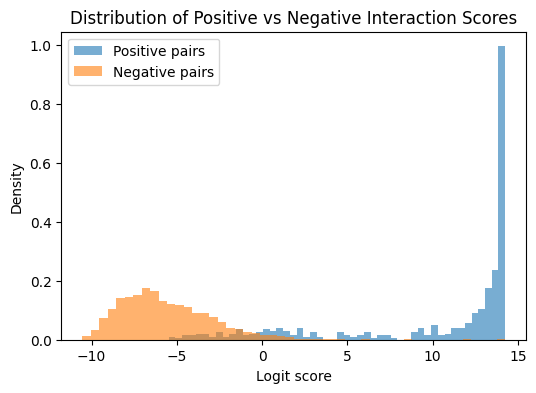

In [54]:
plt.figure(figsize=(6, 4))
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
plt.legend()
plt.show()

#### non-dimers datset

In [55]:
interaction_scores = []
for batch in tqdm(non_dimers_dataloader, total=round(len(non_dimers_Df)/10), desc="#Iterating through batched data"):
    seq_embedding_pep, seq_embedding_prot, str_embedding_pep, str_embedding_prot, lbls = batch
    
    seq_embedding_pep = seq_embedding_pep.to("cuda")
    seq_embedding_prot = seq_embedding_prot.to("cuda")
    str_embedding_pep = str_embedding_pep.to("cuda")
    str_embedding_prot = str_embedding_prot.to("cuda")

    with torch.no_grad():

        rows, cols = torch.triu_indices(seq_embedding_pep.size(0), seq_embedding_pep.size(0), offset=1)
        positive_logits = model(seq_embedding_pep, seq_embedding_prot, str_embedding_pep, str_embedding_prot)
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], str_embedding_pep[rows,:,:], str_embedding_prot[cols,:,:], int_prob=0.0)
        negative_logits = model(seq_embedding_pep[rows,:,:], seq_embedding_prot[cols,:,:], str_embedding_pep[rows,:,:], str_embedding_prot[cols,:,:], int_prob=0.0)
        
        # print(logit_matrix)
        interaction_scores_pos.append(positive_logits)
        interaction_scores_neg.append(negative_logits)

# Convert list of tensors to single 1D tensors
pos_logits = torch.cat(interaction_scores_pos).detach().cpu().numpy()
neg_logits = torch.cat(interaction_scores_neg).detach().cpu().numpy()
print("Positives:", pos_logits.shape)
print("Negatives:", neg_logits.shape)

#Iterating through batched data: 13it [00:09,  1.33it/s]                                                                

Positives: (616,)
Negatives: (2752,)


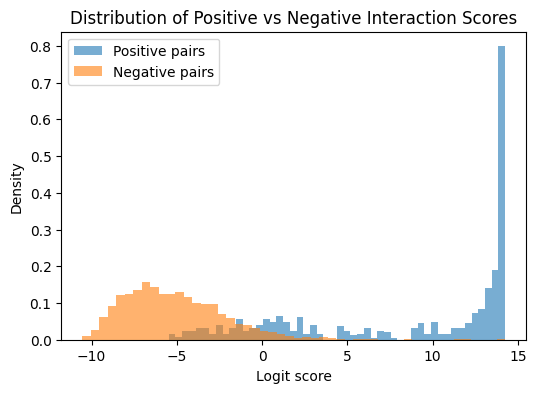

In [56]:
plt.figure(figsize=(6, 4))
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
plt.legend()
plt.show()

#### meta-analysis dataset

In [58]:
# Loading batches
interaction_scores = []

for batch in tqdm(validation_dataloader, total = round(len(interaction_df_shuffled)/10),  desc= "#Iterating through batched data"):
    seq_embedding_pep, seq_embedding_prot, str_embedding_pep, str_embedding_prot, lbls = batch
    
    seq_embedding_pep = seq_embedding_pep.to("cuda")
    seq_embedding_prot = seq_embedding_prot.to("cuda")
    str_embedding_pep = str_embedding_pep.to("cuda")
    str_embedding_prot = str_embedding_prot.to("cuda")

    with torch.no_grad():
        positive_logits = model(seq_embedding_pep, seq_embedding_prot, str_embedding_pep, str_embedding_prot)
        interaction_scores.append(positive_logits.unsqueeze(0))

predicted_interaction_scores = np.concatenate([batch_score.cpu().detach().numpy().reshape(-1,) for batch_score in interaction_scores])
interaction_probabilities = np.concatenate([torch.sigmoid(batch_score[0]).cpu().numpy() for batch_score in interaction_scores])

pos_logits, neg_logits = [], []
for i, row in interaction_df_shuffled.iterrows():
    logit = predicted_interaction_scores[i]
    if row.binder == False:
        neg_logits.append(logit)
    elif row.binder == True:
        pos_logits.append(logit)

#Iterating through batched data: 354it [01:03,  5.58it/s]                                                               


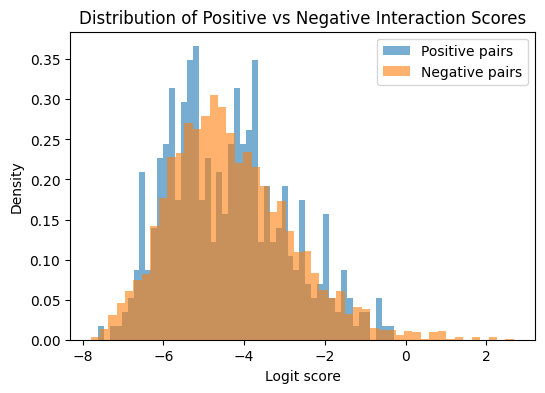

In [59]:
plt.figure(figsize=(6, 4))
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
plt.legend()
plt.show()